In [2]:
import pandas_datareader.data as web
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import gzip, cPickle

from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa as tsa 
from statsmodels.tsa.stattools import coint

from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller as ADF
from sklearn.decomposition import PCA

from itertools import combinations
from tqdm import tqdm

C:\Users\Juntao\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## This step is to download and load all the ETF data

In [4]:
with gzip.open('etf_data.pkl.gz', 'r') as f:
    etf_data = cPickle.load(f)

In [5]:
print etf_data.items

Index([u'Adj Close', u'Close', u'High', u'Low', u'Open', u'Volume'], dtype='object')


In [6]:
etf_adj_close = etf_data['Adj Close']

In [7]:
etf_adj_close.head(10)

,AGG,BND,DIA,IJH,IJR,IVV,IVW,IWD,IWF,IWM,...,QQQ,SPY,VB,VNQ,VO,VOO,VTI,VTV,VUG,XLF
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,NaN,NaN,75.598282,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,84.326424,103.807343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.962534
2000-01-04,NaN,NaN,73.110947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,78.541489,99.747833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.527010
2000-01-05,NaN,NaN,74.057983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,76.539001,99.926254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.452150
2000-01-06,NaN,NaN,74.432602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,71.282539,98.320305,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.867239
2000-01-07,NaN,NaN,76.930359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,80.098961,104.030365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.030557
2000-01-10,NaN,NaN,77.263382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,82.323975,104.387283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.853654
2000-01-11,NaN,NaN,76.690941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,78.319023,103.138176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.690328
2000-01-12,NaN,NaN,76.888748,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,76.594635,102.112160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.880871
2000-01-13,NaN,NaN,77.180145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,81.211464,103.495056,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.180292


In [9]:
etf_adj_close.describe()

,AGG,BND,DIA,IJH,IJR,IVV,IVW,IWD,IWF,IWM,...,QQQ,SPY,VB,VNQ,VO,VOO,VTI,VTV,VUG,XLF
count,3611.000000,2724.000000,4549.000000,4448.000000,4448.000000,4453.000000,4448.000000,4448.000000,4448.000000,4448.000000,...,4549.000000,4549.000000,3526.000000,3359.000000,3526.000000,1862.000000,4183.000000,3526.000000,3526.000000,4549.000000
mean,86.930394,70.045990,107.242970,83.168154,31.732234,124.898869,67.893408,62.092474,59.363704,71.151977,...,59.568182,123.953926,75.605132,51.728748,79.451586,156.089406,64.005436,55.971228,68.739332,12.819685
std,15.247959,8.303227,44.509864,41.645910,16.755602,51.031705,29.542056,24.380947,25.691009,31.631620,...,33.466496,50.106947,30.976955,17.891953,32.450825,42.883662,27.462153,19.747724,28.386684,4.460721
min,62.450512,52.504082,50.846672,30.569809,11.347637,56.697350,31.557692,27.476299,26.770271,26.479548,...,17.853170,56.590065,26.419552,14.874623,29.441034,86.901306,27.245485,22.821577,28.923016,3.305989
25%,71.256919,63.412605,73.254036,48.874684,18.704909,88.490715,47.002032,41.945841,40.847142,45.683989,...,34.430286,89.149017,51.809377,38.789692,55.214540,113.521740,42.532509,40.626559,46.627992,9.554235
50%,88.847816,72.668407,91.779633,70.013386,26.553247,106.160057,55.816995,55.568133,49.372437,62.686336,...,44.410431,105.324783,63.492306,47.932461,68.069004,160.682442,55.184685,48.793667,56.494144,12.483156
75%,100.366474,76.658340,137.089905,115.367346,43.843147,155.113754,83.091437,79.019321,73.113255,97.286611,...,82.438416,151.683365,105.687453,66.610951,109.514168,183.495998,85.766530,73.337204,94.321977,14.402566
max,109.631989,81.763237,265.910004,199.210007,80.360001,288.660004,165.979996,131.539993,146.100006,159.960007,...,170.929993,286.579987,155.070007,87.720032,164.160004,263.359985,146.860001,113.260002,152.380005,30.170000


## Load S&P 500 data

In [19]:
with gzip.open('all_data.pkl.gz', 'r') as f:
    stock_data = cPickle.load(f)

stock_adj_close = stock_data['Adj Close']

GSPC = stock_adj_close['^GSPC']

GSPC.name = 'GSPC'

In [21]:
GSPC.head(10)

Date
2000-01-03    1455.219971
2000-01-04    1399.420044
2000-01-05    1402.109985
2000-01-06    1403.449951
2000-01-07    1441.469971
2000-01-10    1457.599976
2000-01-11    1438.560059
2000-01-12    1432.250000
2000-01-13    1449.680054
2000-01-14    1465.150024
Name: GSPC, dtype: float64

In [23]:
GSPC.describe()

count    4549.000000
mean     1441.853605
std       438.226401
min       676.530029
25%      1135.260010
50%      1317.369995
75%      1658.780029
max      2872.870117
Name: GSPC, dtype: float64

In [24]:
etf_adj_close['GSPC'] = GSPC

In [26]:
etf_adj_close.describe()

,AGG,BND,DIA,IJH,IJR,IVV,IVW,IWD,IWF,IWM,...,SPY,VB,VNQ,VO,VOO,VTI,VTV,VUG,XLF,GSPC
count,3611.000000,2724.000000,4549.000000,4448.000000,4448.000000,4453.000000,4448.000000,4448.000000,4448.000000,4448.000000,...,4549.000000,3526.000000,3359.000000,3526.000000,1862.000000,4183.000000,3526.000000,3526.000000,4549.000000,4549.000000
mean,86.930394,70.045990,107.242970,83.168154,31.732234,124.898869,67.893408,62.092474,59.363704,71.151977,...,123.953926,75.605132,51.728748,79.451586,156.089406,64.005436,55.971228,68.739332,12.819685,1441.853605
std,15.247959,8.303227,44.509864,41.645910,16.755602,51.031705,29.542056,24.380947,25.691009,31.631620,...,50.106947,30.976955,17.891953,32.450825,42.883662,27.462153,19.747724,28.386684,4.460721,438.226401
min,62.450512,52.504082,50.846672,30.569809,11.347637,56.697350,31.557692,27.476299,26.770271,26.479548,...,56.590065,26.419552,14.874623,29.441034,86.901306,27.245485,22.821577,28.923016,3.305989,676.530029
25%,71.256919,63.412605,73.254036,48.874684,18.704909,88.490715,47.002032,41.945841,40.847142,45.683989,...,89.149017,51.809377,38.789692,55.214540,113.521740,42.532509,40.626559,46.627992,9.554235,1135.260010
50%,88.847816,72.668407,91.779633,70.013386,26.553247,106.160057,55.816995,55.568133,49.372437,62.686336,...,105.324783,63.492306,47.932461,68.069004,160.682442,55.184685,48.793667,56.494144,12.483156,1317.369995
75%,100.366474,76.658340,137.089905,115.367346,43.843147,155.113754,83.091437,79.019321,73.113255,97.286611,...,151.683365,105.687453,66.610951,109.514168,183.495998,85.766530,73.337204,94.321977,14.402566,1658.780029
max,109.631989,81.763237,265.910004,199.210007,80.360001,288.660004,165.979996,131.539993,146.100006,159.960007,...,286.579987,155.070007,87.720032,164.160004,263.359985,146.860001,113.260002,152.380005,30.170000,2872.870117


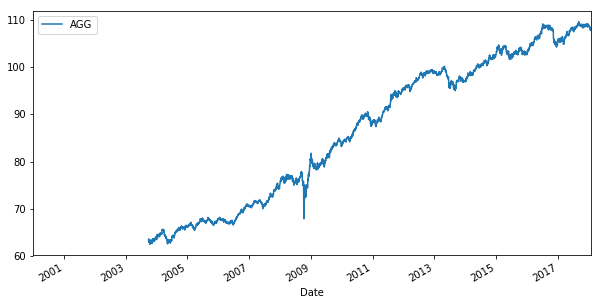

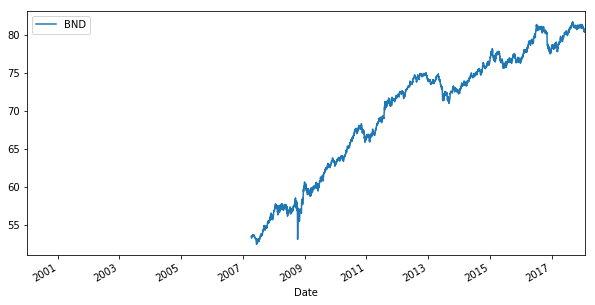

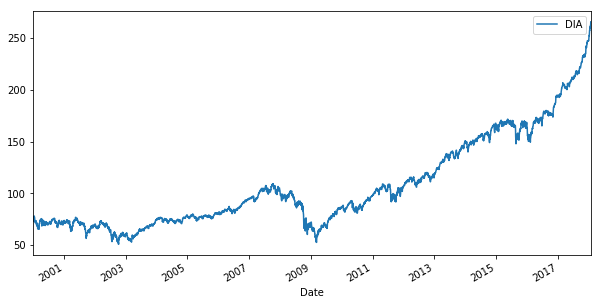

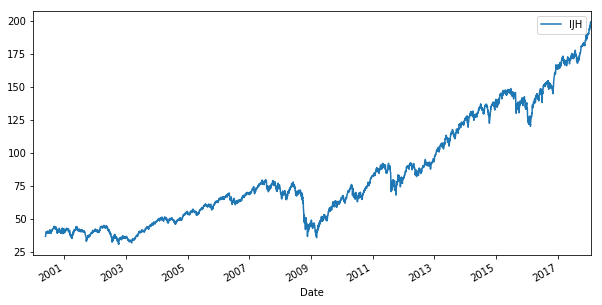

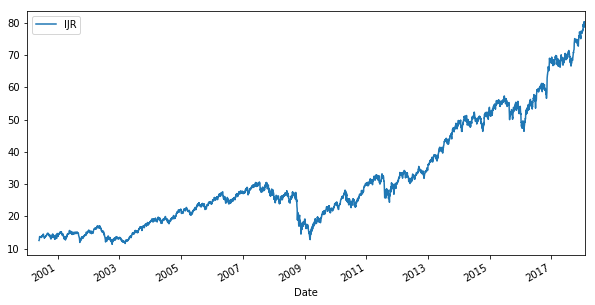

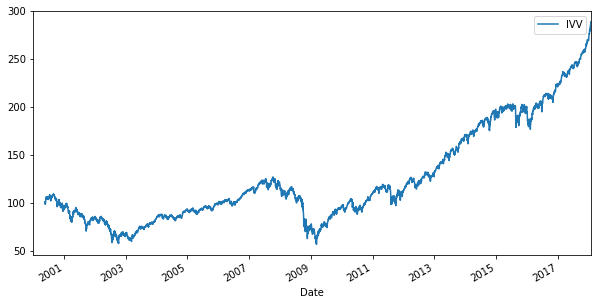

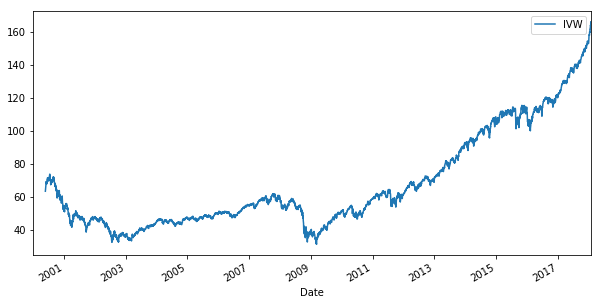

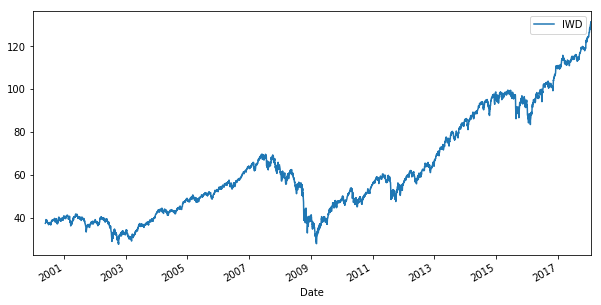

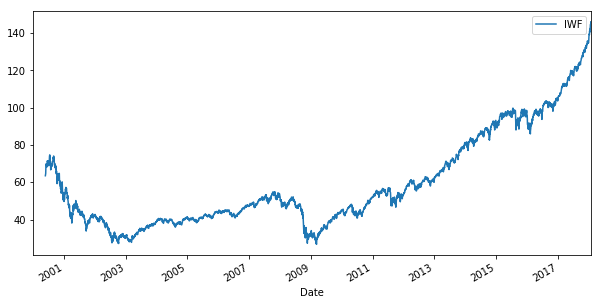

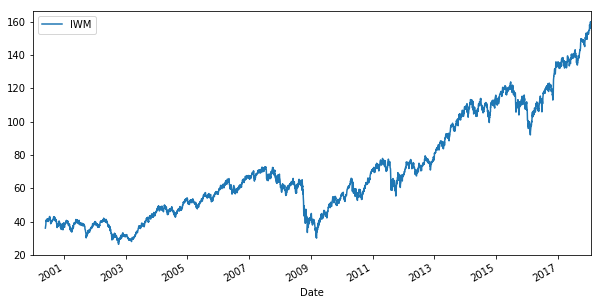

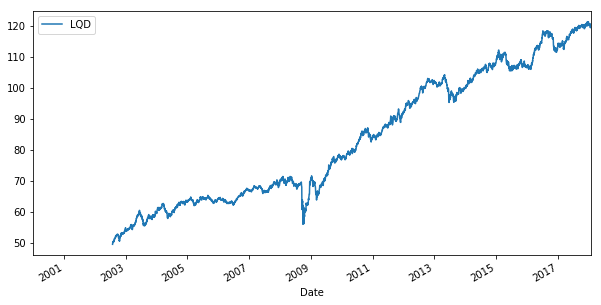

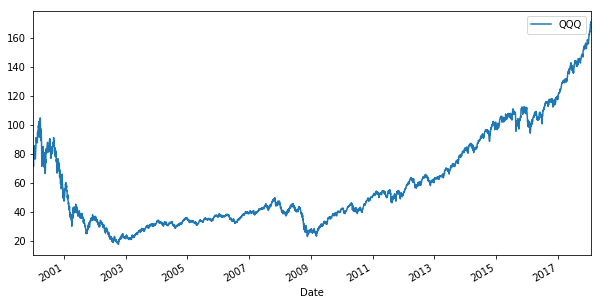

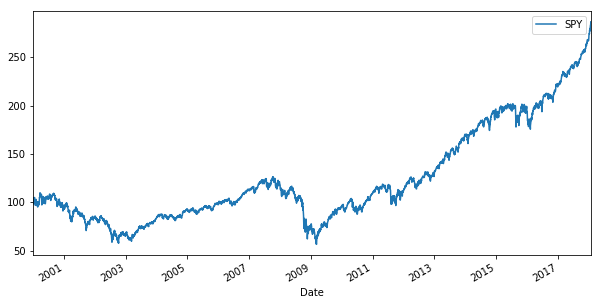

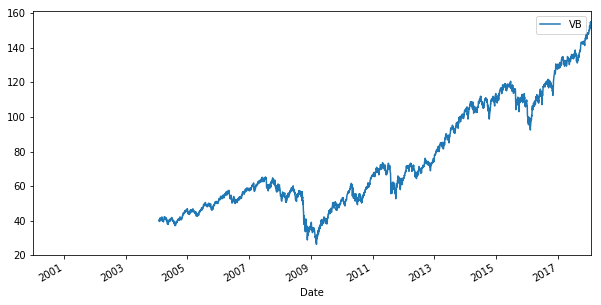

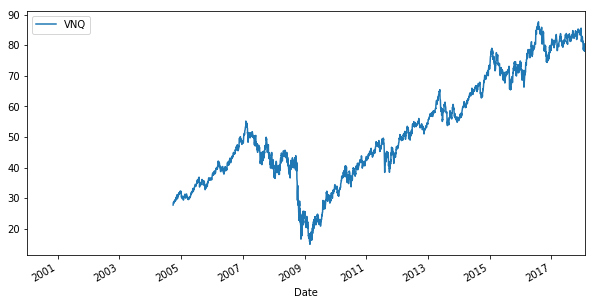

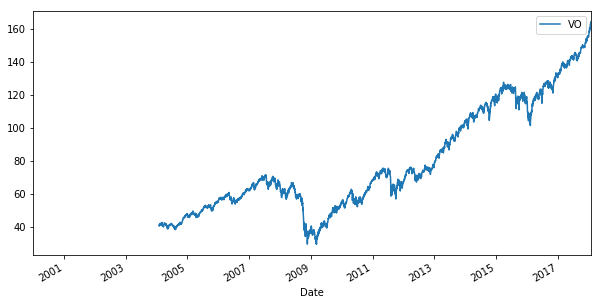

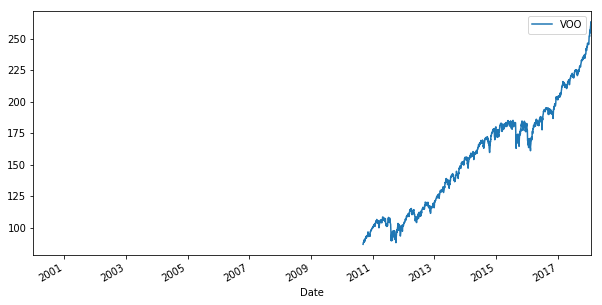

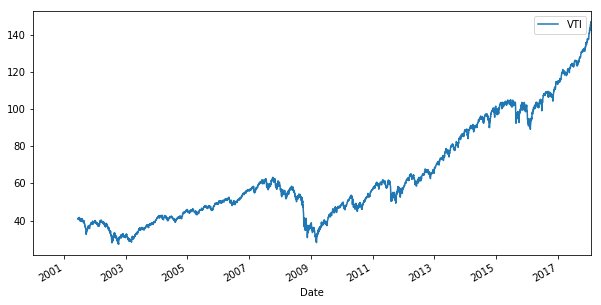

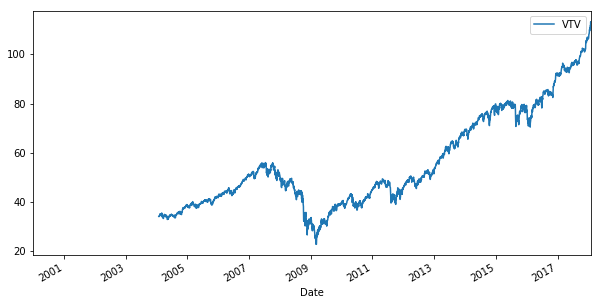

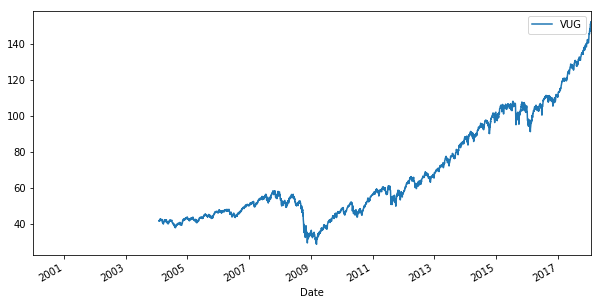

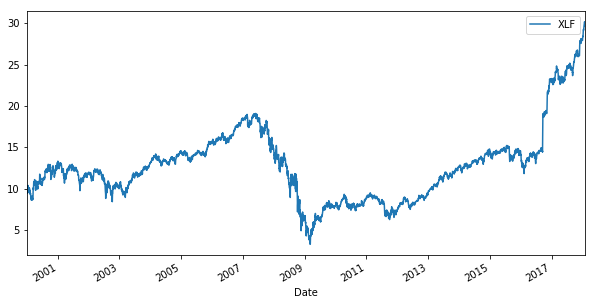

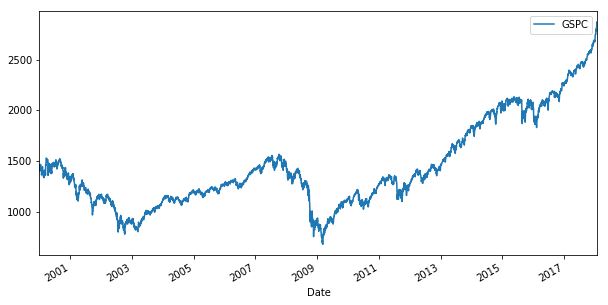

In [34]:
for i in etf_adj_close.columns:

    etf_adj_close[[i]].plot(figsize=(10,5))

    plt.show()


In [37]:
etf_adj_close_log = etf_adj_close.apply(np.log)

In [39]:
etf_adj_close_log.head()

,AGG,BND,DIA,IJH,IJR,IVV,IVW,IWD,IWF,IWM,...,SPY,VB,VNQ,VO,VOO,VTI,VTV,VUG,XLF,GSPC
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,NaN,NaN,4.325434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.642537,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.298831,7.282912
2000-01-04,NaN,NaN,4.291978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.602645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.254131,7.243813
2000-01-05,NaN,NaN,4.304848,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.604432,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.246242,7.245734
2000-01-06,NaN,NaN,4.309894,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.588231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.289220,7.246689
2000-01-07,NaN,NaN,4.342901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.644683,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.305636,7.273419


In [40]:
etf_adj_close.head()

,AGG,BND,DIA,IJH,IJR,IVV,IVW,IWD,IWF,IWM,...,SPY,VB,VNQ,VO,VOO,VTI,VTV,VUG,XLF,GSPC
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,NaN,NaN,75.598282,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,103.807343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.962534,1455.219971
2000-01-04,NaN,NaN,73.110947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,99.747833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.527010,1399.420044
2000-01-05,NaN,NaN,74.057983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,99.926254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.452150,1402.109985
2000-01-06,NaN,NaN,74.432602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98.320305,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.867239,1403.449951
2000-01-07,NaN,NaN,76.930359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,104.030365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.030557,1441.469971


In [237]:
etf_adj_close_log.head()

,AGG,BND,DIA,IJH,IJR,IVV,IVW,IWD,IWF,IWM,...,SPY,VB,VNQ,VO,VOO,VTI,VTV,VUG,XLF,GSPC
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,NaN,NaN,4.325434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.642537,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.298831,7.282912
2000-01-04,NaN,NaN,4.291978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.602645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.254131,7.243813
2000-01-05,NaN,NaN,4.304848,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.604432,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.246242,7.245734
2000-01-06,NaN,NaN,4.309894,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.588231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.289220,7.246689
2000-01-07,NaN,NaN,4.342901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.644683,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.305636,7.273419


In [116]:
for i in etf_adj_close_log.columns:

    name = i+'_adj_closed_log'

    print(name)

    globals()[name] = etf_adj_close_log[[i]]
 

AGG_adj_closed_log
BND_adj_closed_log
DIA_adj_closed_log
IJH_adj_closed_log
IJR_adj_closed_log
IVV_adj_closed_log
IVW_adj_closed_log
IWD_adj_closed_log
IWF_adj_closed_log
IWM_adj_closed_log
LQD_adj_closed_log
QQQ_adj_closed_log
SPY_adj_closed_log
VB_adj_closed_log
VNQ_adj_closed_log
VO_adj_closed_log
VOO_adj_closed_log
VTI_adj_closed_log
VTV_adj_closed_log
VUG_adj_closed_log
XLF_adj_closed_log
GSPC_adj_closed_log


In [247]:
XLF_adj_closed_log.columns[0]

'XLF'

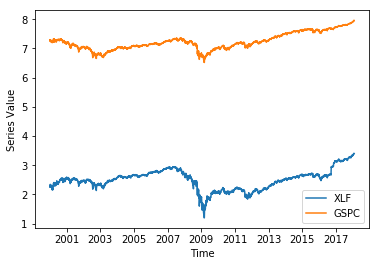

In [250]:
plt.plot(XLF_adj_closed_log.index, XLF_adj_closed_log.values)
plt.plot(GSPC_adj_closed_log.index, GSPC_adj_closed_log.values)
plt.xlabel('Time')
plt.ylabel('Series Value')
plt.legend([XLF_adj_closed_log.columns[0], GSPC_adj_closed_log.columns[0]])
plt.show()

##  let's do the stationary test for log price of every ETF and GSPC in the dataframe 

In [94]:
j = 0
for i in etf_adj_close_log.columns:
    etf = etf_adj_close_log[[i]].dropna(axis=0,how = 'any')
    pvalue = ADF(etf.values.flatten())[1]
    if pvalue < 0.01:
        print("original %s is stationary, cause pvalues is %s less than 0.01" % (i, pvalue))
    else:
        etf = etf.diff(1).dropna() 
        pvalue = ADF(etf.values.flatten())[1]
        if pvalue < 0.01:
            j+=1
            print("%s is stationary in first difference , cause pvalues is %s less than 0.01" % (i, pvalue))
        else:
            print("%s is not stationary in first difference, and the p-value is %s" %(i,pvalue))


print('\n')            
print("total number of assests is %s"%(etf_adj_close_log.shape[1]))
print('\n')
print ("total number of Integration of order 1 is %s"%(j))

AGG is stationary in first difference , cause pvalues is 4.96167985047e-20 less than 0.01
BND is stationary in first difference , cause pvalues is 4.71746457128e-21 less than 0.01
DIA is stationary in first difference , cause pvalues is 9.18120318382e-29 less than 0.01
IJH is stationary in first difference , cause pvalues is 1.07444449658e-27 less than 0.01
IJR is stationary in first difference , cause pvalues is 7.89124651151e-28 less than 0.01
IVV is stationary in first difference , cause pvalues is 4.94746167176e-29 less than 0.01
IVW is stationary in first difference , cause pvalues is 1.36261586611e-28 less than 0.01
IWD is stationary in first difference , cause pvalues is 1.27706952914e-26 less than 0.01
IWF is stationary in first difference , cause pvalues is 2.15424059847e-28 less than 0.01
IWM is stationary in first difference , cause pvalues is 9.6454043161e-28 less than 0.01
LQD is stationary in first difference , cause pvalues is 1.22414596186e-24 less than 0.01
QQQ is stat

## From above, we can see every asset is integrated of order 1

In [176]:
a

[1, 2, 3, 4, 4, 6, 65, -1]

In [177]:
a[:-1]

[1, 2, 3, 4, 4, 6, 65]

In [307]:
%%time
m = 0
n = 0
for i in combinations(range(21), 16):
    n+=1
    columns = list(i)
    columns.append(-1)
    #GSPC_adj_closed_log
    R_M = LinearRegression()
    data = etf_adj_close_log.iloc[:,columns].dropna(axis=0,how = 'any')
    X_part = data.iloc[:,:-1]
    Y = data.iloc[:,-1]
    R_M.fit(X_part,Y) 
    residual = Y - R_M.predict(X_part) 
    if (check_for_stationarity_no_print(residual.values.flatten()) and  sum(R_M.coef_ < 0) <=5 ):
        m+=1
        print (columns)
        #print (data.head(10))
    
#     if n == 1000:
#         break

# X_part_constant = sm.add_constant(X_part)

# sm_ols_results = sm.OLS(Y, X_part_constant).fit()

# print(sm_ols_results.params)

# print(sm_ols_results.summary())    

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, -1]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 16, 19, 20, -1]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 19, 20, -1]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, -1]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 16, 17, -1]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 16, 20, -1]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 16, 17, 19, 20, -1]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, -1]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 16, 19, -1]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 16, 19, -1]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17, 19, -1]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16, 19, -1]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 15, 16, 17, 19, -1]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, -1]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 15, 16, 19, 20, -1]


KeyboardInterrupt: 

In [309]:
m

15

In [308]:
n

366

In [313]:
sum(R_M.coef_ < 0) <=5

False

In [326]:
columns = [ 2,7, 8, 12, 15, 19,  -1]

In [327]:
data = etf_adj_close_log.iloc[:,columns].dropna(axis=0,how = 'any')
X_part = data.iloc[:,:-1]
Y = data.iloc[:,-1]
R_M.fit(X_part,Y) 
residual = Y - R_M.predict(X_part) 


In [328]:
if (check_for_stationarity_no_print(residual.values.flatten()) and  sum(R_M.coef_ < 0) <=5 ):
    print (columns)
 

In [320]:
data.head()

,AGG,BND,DIA,IJH,IJR,IVV,IVW,IWD,IWF,IWM,QQQ,SPY,VO,VOO,VUG,XLF,GSPC
Date,,,,,,,,,,,,,,,,,
2010-09-09,4.490172,4.206631,4.470938,4.227214,3.187086,4.558783,3.924800,3.891131,3.787678,4.040202,3.754840,4.555260,4.045538,4.464773,3.864031,2.075554,7.006858
2010-09-10,4.488034,4.205409,4.476010,4.230095,3.189047,4.564428,3.930749,3.895429,3.792353,4.043346,3.758494,4.560296,4.049631,4.469303,3.869162,2.076932,7.011710
2010-09-13,4.490265,4.207973,4.484468,4.247854,3.212113,4.575357,3.942025,3.908216,3.803643,4.067380,3.772346,4.571358,4.064601,4.481801,3.880658,2.098043,7.022779
2010-09-14,4.493878,4.209436,4.482289,4.249010,3.208975,4.574561,3.942714,3.905672,3.805846,4.063080,3.776570,4.570737,4.063827,4.481606,3.881968,2.089244,7.022066
2010-09-15,4.492027,4.208461,4.487020,4.252725,3.215242,4.578268,3.947701,3.908216,3.809839,4.068757,3.782873,4.574547,4.067538,4.484126,3.887008,2.092637,7.025600


In [329]:
X_part_constant = sm.add_constant(X_part)

sm_ols_results = sm.OLS(Y, X_part_constant).fit()

print(sm_ols_results.params)

print(sm_ols_results.summary())    

const    5.914714
DIA     -0.271451
IWD      2.437993
IWF      3.108869
SPY     -2.737414
VO      -0.570257
VUG     -1.081643
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                   GSPC   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 2.079e+05
Date:                Tue, 08 May 2018   Prob (F-statistic):               0.00
Time:                        16:09:41   Log-Likelihood:                 9787.7
No. Observations:                3526   AIC:                        -1.956e+04
Df Residuals:                    3519   BIC:                        -1.952e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025   

In [ ]:
(list(combinations(range(21), 16)))

In [95]:
def check_for_stationarity(X, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = ADF(X)[1]
    if pvalue < cutoff:
        print 'p-value = ' + str(pvalue) + ' The series '  +' is likely stationary.'
        return True
    else:
        print 'p-value = ' + str(pvalue) + ' The series '+' is likely non-stationary.'
        return False

In [104]:
def check_for_stationarity_no_print(X, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = ADF(X)[1]
    if pvalue < cutoff:
        #print 'p-value = ' + str(pvalue) + ' The series '  +' is likely stationary.'
        return True
    else:
        #print 'p-value = ' + str(pvalue) + ' The series '+' is likely non-stationary.'
        return False

In [232]:
 for i in etf_adj_close_log.columns:
    etf = etf_adj_close_log[[i]].dropna(axis=0,how = 'any')
    if check_for_stationarity_no_print(etf.values.flatten()):
        print "great"

# Load useful ETFs dataset


In [89]:
X = pd.DataFrame()
tickers = ['IYR','XLK','XLF','XLY','XLP','XLU','XLV','XLE','VOX','XLI','XLB']
#['^GSPC','XLRE','XLK','XLF','XLY','XLP','XLU','XLV','XLE','VOX','XLI','XLB']
start_date = '2010-01-01'
end_date = '2018-01-31'
data_source = 'yahoo'
# User pandas_reader.data.DataReader to load the desired data. As simple as that.
for i in tickers:
    print i
    etf_data= web.DataReader(i, data_source, start_date, end_date)
    new_col = etf_data[['Adj Close']]
    new_col.columns = [i]
    X =  pd.concat([X, new_col], axis=1)
 

IYR
XLK
XLF
XLY
XLP
XLU
XLV
XLE
VOX
XLI
XLB


In [91]:
X.head()

,IYR,XLK,XLF,XLY,XLP,XLU,XLV,XLE,VOX,XLI,XLB
Date,,,,,,,,,,,
2010-01-04,33.326984,20.260942,7.893192,26.571135,21.404194,22.858370,27.479057,48.912964,43.934830,23.942719,28.269466
2010-01-05,33.406994,20.234821,8.038269,26.668564,21.412218,22.586250,27.209570,49.312183,44.231682,24.027264,28.360874
2010-01-06,33.392452,20.008436,8.054389,26.703989,21.396170,22.718626,27.487759,49.902706,43.531406,24.077988,28.842829
2010-01-07,33.690731,19.930080,8.226331,26.925417,21.396170,22.615664,27.583380,49.827847,43.371559,24.340065,28.618462
2010-01-08,33.465195,20.060682,8.177971,26.916557,21.323935,22.593601,27.626846,50.152218,43.173656,24.728971,29.017332


In [90]:
X.describe()

,IYR,XLK,XLF,XLY,XLP,XLU,XLV,XLE,VOX,XLI,XLB
count,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000
mean,58.370344,34.521567,13.054506,58.026272,38.060676,35.667436,51.529946,64.976448,68.586054,44.294312,39.777969
std,13.415134,11.988799,5.616238,20.805814,11.036042,9.492095,18.835942,9.989513,16.299077,13.848242,8.900407
min,30.882559,17.785233,6.185334,25.322285,20.658789,20.843229,24.511381,41.401642,38.819752,22.742197,23.462399
25%,47.300425,23.778251,8.521603,37.112534,27.433789,27.801294,32.160600,59.409230,52.676979,31.855479,32.381380
50%,57.622471,32.841522,12.274555,60.406591,38.080887,33.824341,52.369179,64.832993,71.429542,46.479862,40.032555
75%,69.836412,41.335567,14.333039,75.765236,47.495223,43.105857,68.750421,71.240442,79.607941,53.076354,46.186456
max,81.375084,68.974213,30.060575,108.680023,58.382065,55.910404,91.219521,91.126648,99.392113,80.336220,63.846069


In [106]:
GSPC = web.DataReader("^GSPC", "yahoo",start_date,end_date)
GSPC = GSPC[['Adj Close']]

In [95]:
GSPC.head()

,Adj Close
Date,
2010-01-04,1132.989990
2010-01-05,1136.520020
2010-01-06,1137.140015
2010-01-07,1141.689941
2010-01-08,1144.979980


In [34]:
tickers

['^GSPC']

In [94]:
import pandas_datareader as pdr
pdr.get_data_yahoo('XLF').head()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,11.795288,11.965881,11.770918,11.933388,7.893192,92942300
2010-01-05,11.917141,12.152721,11.900893,12.152721,8.038269,96770000
2010-01-06,12.144598,12.225833,12.055240,12.177092,8.054389,75492700
2010-01-07,12.201462,12.510155,12.177092,12.437043,8.226331,117869100
2010-01-08,12.372055,12.437043,12.266450,12.363932,8.177971,111866100


In [103]:
X_log.head()

,IYR,XLK,XLF,XLY,XLP,XLU,XLV,XLE,VOX,XLI,XLB
Date,,,,,,,,,,,
2010-01-04,3.506367,3.008695,2.066001,3.279825,3.063587,3.129317,3.313424,3.890042,3.782707,3.175664,3.341782
2010-01-05,3.508765,3.007405,2.084214,3.283485,3.063962,3.117341,3.303569,3.898171,3.789441,3.179189,3.345011
2010-01-06,3.508330,2.996154,2.086217,3.284813,3.063212,3.123185,3.313741,3.910075,3.773483,3.181298,3.361861
2010-01-07,3.517223,2.992230,2.107340,3.293071,3.063212,3.118643,3.317213,3.908574,3.769804,3.192124,3.354052
2010-01-08,3.510506,2.998762,2.101444,3.292742,3.059830,3.117667,3.318788,3.915063,3.765230,3.207975,3.367893


In [115]:
X_log = X.apply(np.log)

X_constant = sm.add_constant(X_log)

GSPC_log = np.log(GSPC)

sm_ols_results = sm.OLS(GSPC_log, X_constant).fit()

print(sm_ols_results.params)

print(sm_ols_results.summary())    

const    4.379973
IYR      0.052998
XLK      0.151185
XLF      0.053943
XLY      0.052130
XLP      0.084042
XLU     -0.094653
XLV      0.204318
XLE      0.073398
VOX     -0.037952
XLI      0.187055
XLB      0.101408
dtype: float64
                            OLS Regression Results                            
Dep. Variable:              Adj Close   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.451e+05
Date:                Wed, 09 May 2018   Prob (F-statistic):               0.00
Time:                        00:34:26   Log-Likelihood:                 7498.2
No. Observations:                2034   AIC:                        -1.497e+04
Df Residuals:                    2022   BIC:                        -1.491e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                     

In [117]:
ADF(sm_ols_results.resid.values.flatten())

(-6.0311190943928024,
 1.4172077521992743e-07,
 6L,
 2027L,
 {'1%': -3.4335801926672382,
  '10%': -2.567529637785797,
  '5%': -2.8629669356419787},
 -19888.213380400925)